# Cost-Optimal Task Scheduling in Battery Assisted Mobile Edge Computing

## Parameters

In [68]:
import numpy as np

bs_num = 3
w = np.array([
    [0, -5, -2],
    [2, 0, -7],
    [-5,2, 0],
])

arrival_rates = [4,3,5]

## Subproblem 1

$
\begin{align}
\min_{\mathbf{x}} \quad & \sum_{i}\left[ \sum_{j\in\mathcal{B}, j\neq i}\left(\frac{p_i c_i^G}{\mu_i} - \frac{p_i\pi_i}{\mu_i}\right)x_{ji} + \sum_{j\in\mathcal{B}, j\neq i} \left(c_{ij} - \frac{p_i c_i^G}{\mu_i} + \frac{p_i\pi_i}{\mu_i} \right)x_{ij} \right] \\
s.t. \quad & \sum_{j\in\mathcal{B}, j\neq i} x_{ij}\leq \lambda_i,~i\in\mathcal{B} \\
           & x_{ij}\in\mathbb{N},~i,j\in\mathcal{B},~i\neq j
\end{align}
$

Let 
$$
a_i = \left(\frac{p_i c_i^G}{\mu_i} - \frac{p_i\pi_i}{\mu_i}\right) \quad b_{ij} = \left(c_{ij} - \frac{p_i c_i^G}{\mu_i} + \frac{p_i\pi_i}{\mu_i} \right)
$$
The problem is reformualted as follows.
$
\begin{align}
\min_{\mathbf{x}} \quad & \sum_{i}\left[ \sum_{j\in\mathcal{B}, j\neq i}a_i x_{ji} + \sum_{j\in\mathcal{B}, j\neq i} b_{ij}x_{ij} \right] \\
s.t. \quad & \sum_{j\in\mathcal{B}, j\neq i} x_{ij}\leq \lambda_i,~i\in\mathcal{B} \\
           & x_{ij}\in\mathbb{N},~i,j\in\mathcal{B},~i\neq j
\end{align}
$


<img src="networkflow.png" alt="Drawing" style="width: 600px;"/>

In [69]:
# from ortools.graph.python import min_cost_flow

# smcf = min_cost_flow.SimpleMinCostFlow()



In [74]:
import networkx as nx

G = nx.DiGraph()

G.add_node('S', demand = -np.sum(arrival_rates))
G.add_node('D', demand = np.sum(arrival_rates))


for i in range(bs_num):
    G.add_node(f'L{i}')
    G.add_node(f'R{i}')


for i in range(bs_num):
    G.add_edge('S', f'L{i}', capacity = arrival_rates[i])

for i in range(bs_num):
    for j in range(bs_num):
        if i == j:
            continue
        G.add_edge(f'L{i}', f'R{j}', weight = w[i][j])


for i in range(bs_num):
    G.add_edge(f'R{i}', 'D')


G.add_edge('S', 'D')

In [77]:
flowCost, flowDict = nx.network_simplex(G)

print('Minimum cost:', flowCost)
print('')

Minimum cost: -66



In [130]:
flowDict

{'S': {'L0': 4, 'L1': 3, 'L2': 5, 'D': 0},
 'D': {},
 'L0': {'R1': 4, 'R2': 0},
 'R0': {'D': 5},
 'L1': {'R0': 0, 'R2': 3},
 'R1': {'D': 4},
 'L2': {'R0': 5, 'R1': 0},
 'R2': {'D': 3}}

In [180]:
flows = {}
for L, value in flowDict.items():
    for R, w in value.items():
        if w > 0:
            flows[(L, R)] = w

In [181]:
node_pos = {}

y_pos_step = 0.2
x_step = 1
for i in range(bs_num):
    node_pos[f'L{i}'] = (x_step*1, y_pos_step * i)
    node_pos[f'R{i}'] = (x_step*2, y_pos_step * i)

node_pos['S'] = (0, y_pos_step * bs_num )
node_pos['D'] = (x_step*3, y_pos_step * bs_num )

In [182]:
node_pos

{'L0': (1, 0.0),
 'R0': (2, 0.0),
 'L1': (1, 0.2),
 'R1': (2, 0.2),
 'L2': (1, 0.4),
 'R2': (2, 0.4),
 'S': (0, 0.6000000000000001),
 'D': (3, 0.6000000000000001)}

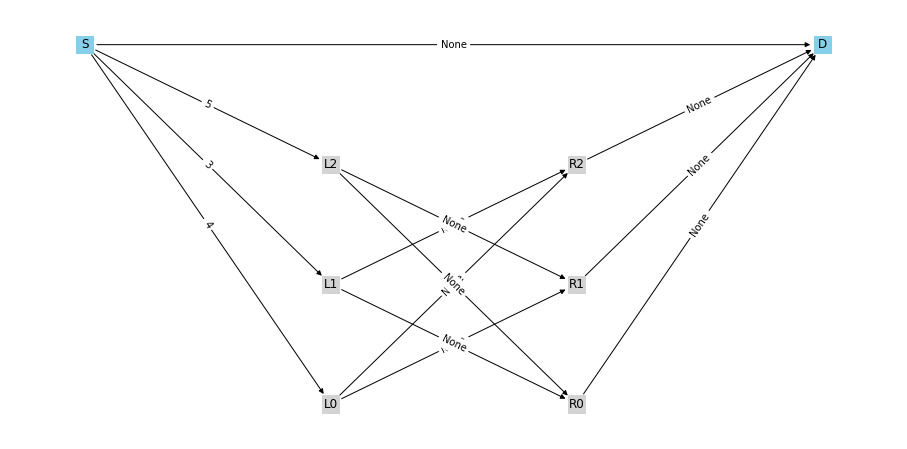

In [183]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16, 8))

capacities = {(u, v): c for u, v, c in G.edges(data="capacity")};
node_colors = ["skyblue" if n in {"S", "D"} else "lightgray" for n in G.nodes]


nx.draw(G, node_pos, with_labels = True, node_color=node_colors, node_shape='s')
nx.draw_networkx_edge_labels(G, node_pos, edge_labels=capacities);


In [184]:
import math

def check_valid_flow(G, flow, source_node, target_node):
    H = nx.DiGraph()
    H.add_edges_from(flow.keys())

    for (u, v), f in flow.items():
        capacity = G[u][v].get("capacity", np.inf)
        H[u][v]["label"] = f"{f}/{capacity}"
        # Capacity constraint
        if f > G[u][v].get("capacity", np.inf):
            H[u][v]["edgecolor"] = "red"
            print(f"Invalid flow: capacity constraint violated for edge ({u!r}, {v!r})")
        # Conservation of flow
        if v not in {source_node, target_node}:
            incoming_flow = sum(
                flow[(i, v)] if (i, v) in flow else 0 for i in G.predecessors(v)
            )
            outgoing_flow = sum(
                flow[(v, o)] if (v, o) in flow else 0 for o in G.successors(v)
            )
            if not math.isclose(incoming_flow, outgoing_flow):
                print(f"Invalid flow: flow conservation violated at node {v}")
                H.nodes[v]["color"] = "red"
    return H

def visualize_flow(flow_graph):
    """Visualize flow returned by the `check_valid_flow` funcion."""
    fig, ax = plt.subplots(figsize=(15, 9))

    # Draw the full graph for reference
    nx.draw(
        G, node_pos, ax=ax, node_color=node_colors, edge_color="lightgrey", with_labels=True
    )

    # Draw the example flow on top
    flow_nc = [
        "skyblue" if n in {"S", "D"} else flow_graph.nodes[n].get("color", "lightgrey")
        for n in flow_graph
    ]
    flow_ec = [flow_graph[u][v].get("edgecolor", "black") for u, v in flow_graph.edges]
    edge_labels = {(u, v): lbl for u, v, lbl in flow_graph.edges(data="label")}
    nx.draw(flow_graph, node_pos, ax=ax, node_color=flow_nc, edge_color=flow_ec)
    nx.draw_networkx_edge_labels(G, node_pos, edge_labels=edge_labels, ax=ax);

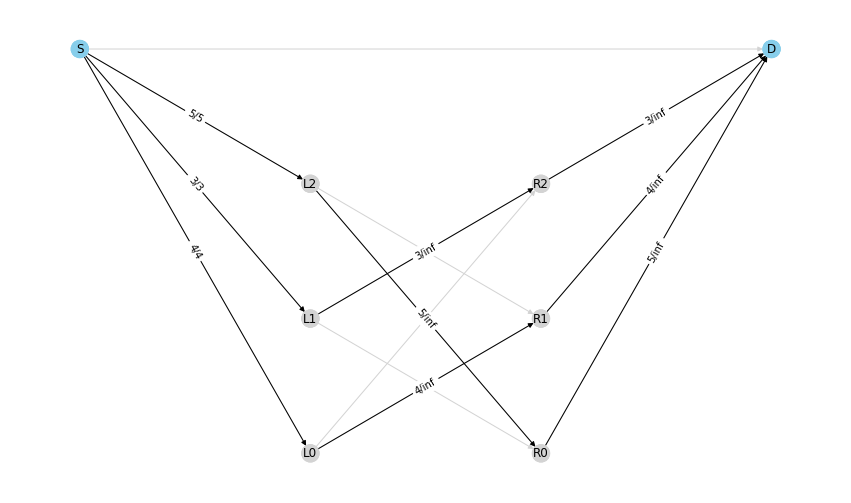

In [185]:
flow_graph=check_valid_flow(G, flows, source_node='S', target_node='D')
visualize_flow(flow_graph)

In [145]:
G['S']['L1']

{'capacity': 3}

## Subproblem 2

\begin{align}
\min_{\mathbf{P}^{D}} \quad & \sum_{i}\left[ \alpha \left(\frac{P_i^D}{P_i^S}\right)^{k_p} - P_i^D(c_i^G-c_i^D-\pi_i) \right] \\
s.t. \quad & P_i^D\geq 0,~i\in\mathcal{B} \\
\end{align}
$$